<a href="https://colab.research.google.com/github/goldboy225/Intelligent-IoT-Security-Frameworks/blob/main/TON_IoT_Framework_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount the google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

# 1. Data Collection

## 1.1 Import libraries

In [3]:
# install 3rd party lib for lightweight pandas
# https://modin.readthedocs.io/en/stable/ https://github.com/modin-project/modin

pip install modin

SyntaxError: ignored

In [9]:
# data cleaning and plots
import pandas as pd
#import modin.pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# sklearn: data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import missingno

# sklearn: train model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report, plot_roc_curve

# sklearn classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# optimization algorithms
from sklearn.model_selection import GridSearchCV
import itertools
import matplotlib.gridspec as gridspec 

# timestamp for noting time resource operation
from pandas import Timestamp

# os lib
import os  # print ("current directory : %s" % os.getcwd())

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## 1.2 Load the dataset

In [10]:
# load the original dataset, which have not been processed by the authors
df = pd.read_csv('/content/drive/MyDrive/Datasets/TON-IoT/Train_Test_Network.csv')

## 1.3 Data Sanity Check

In [ ]:
# Check the dataframe

df.head(10)

In [ ]:
df.info()

In [ ]:
# check the size of the data

print(df.shape)

In [ ]:
# Check the columns of the data

print(df.columns)

In [ ]:
df.describe(include = 'all').T

# 2. Exploration Data Analysis (EDA)

## 2.1 Check the count and distribution of target classes

In [ ]:
# to install matplotlib in order to show the figure in the following steps

#! python -m pip uninstall matplotlib
#! pip install matplotlib==3.1.3


# Check the count of normal and attack class

counts = df.value_counts('label')
print(counts)

label
0    300000
1    161043
dtype: int64


AttributeError: ignored

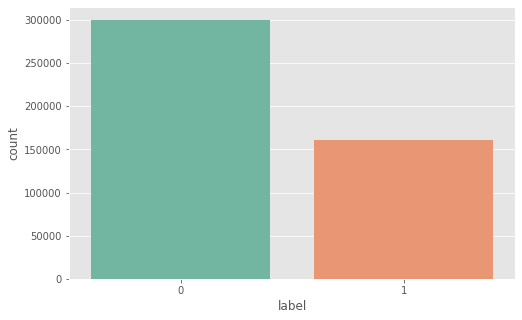

In [ ]:
# let's see the distribution of our target normal/attack by bar chart

plt.figure(figsize=(8,5))
ax = sns.countplot(x = 'label', data = df, palette = 'Set2')
for container in ax.containers:
    ax.bar_label(container)

In [ ]:
# Check the count of category class

counts = df.value_counts('type')
print(counts)

type
normal        300000
backdoor       20000
ddos           20000
dos            20000
injection      20000
password       20000
ransomware     20000
scanning       20000
xss            20000
mitm            1043
dtype: int64


AttributeError: ignored

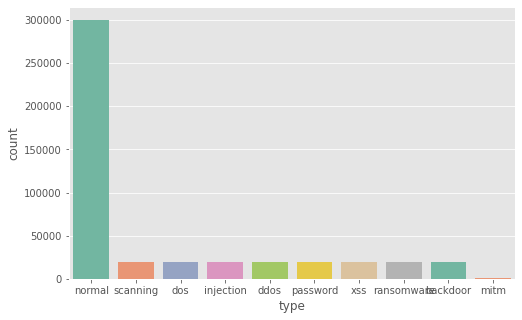

In [ ]:
# let's see the distribution of our target category by bar chart

plt.figure(figsize=(8,5))
ax = sns.countplot(x = 'type', data = df, palette = 'Set2')
for container in ax.containers:
    ax.bar_label(container)

In [ ]:
# helper function for drawing mulitple charts.

def bake_pies(data_list,labels):
    list_length = len(data_list)
    
    # setup for mapping colors
    color_list = sns.color_palette()
    color_cycle = itertools.cycle(color_list)
    cdict = {}
    
    # build the subplots
    fig, axs = plt.subplots(1, list_length,figsize=(18,10), tight_layout=False)
    plt.subplots_adjust(wspace=1/list_length)
    
    # loop through the data sets and build the charts
    for count, data_set in enumerate(data_list): 
        # update our color mapt with new values
        for num, value in enumerate(np.unique(data_set.index)):
            if value not in cdict:
                cdict[value] = next(color_cycle)
       
        # build the wedges
        wedges,texts = axs[count].pie(data_set,
                           colors=[cdict[v] for v in data_set.index])

        # build the legend
        axs[count].legend(wedges, data_set.index,
                           title="Flags",
                           loc="center left",
                           bbox_to_anchor=(1, 0, 0.5, 1))
        # set the title
        axs[count].set_title(labels[count])
        
    return axs

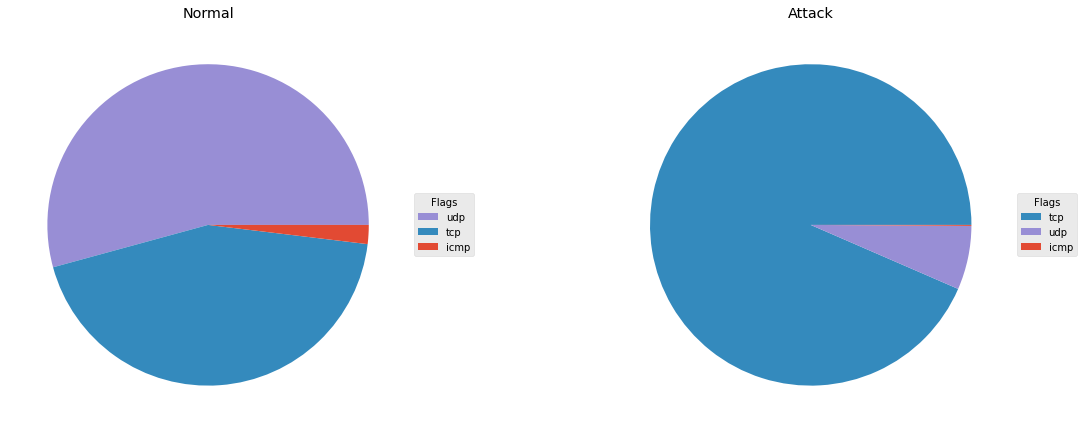

In [ ]:
# Use pie chart to show the distribution of the target classes based on the protocols

normal_protocol = df.loc[df.label == 0].proto.value_counts()
attack_protocol = df.loc[df.label == 1].proto.value_counts()

protocol_axs = bake_pies([normal_protocol, attack_protocol], ['Normal','Attack'])
plt.show()

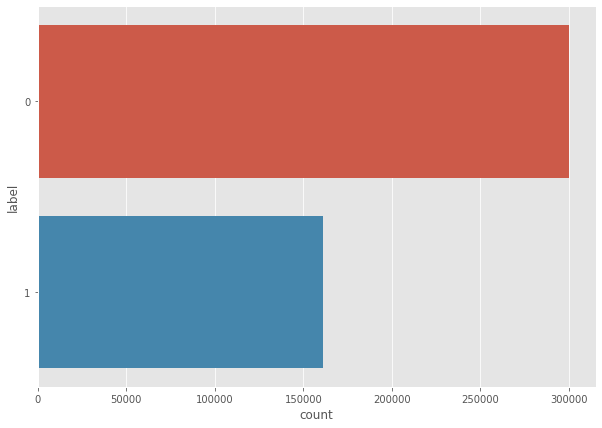

In [ ]:
# let's see the target classses using another bar chart

plt.figure(figsize=(10,7))
sns.countplot(y='label' , data=df, order = df['label'].value_counts().index)

## 2.2 Check the corrlelation between variables

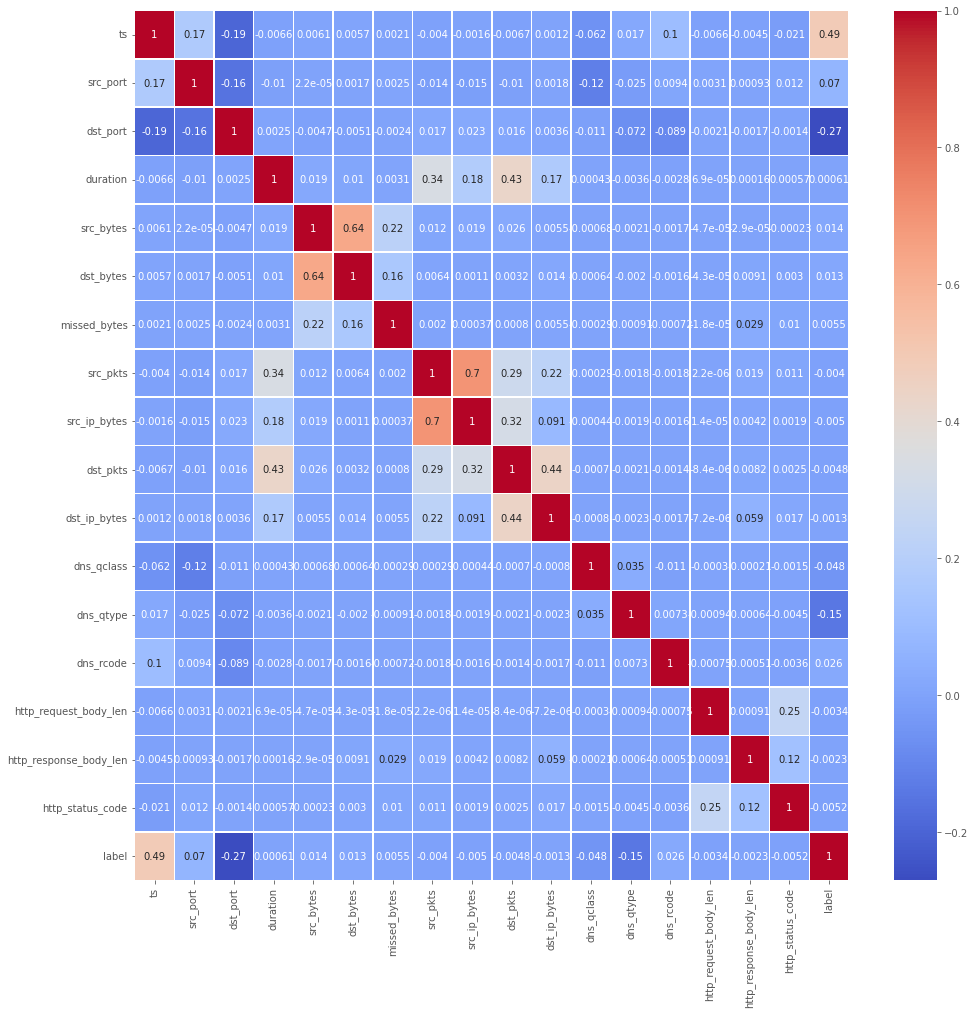

In [ ]:
# Check the correlation matrix between among the attributes

corr = df.corr()
#sns.heatmap(corr, annot=True, cmap='coolwarm')

fig, ax = plt.subplots(figsize=(16,16))         # Sample figsize in inches
sns.heatmap(corr, annot = True, cmap='coolwarm', linewidths=.5, ax=ax)

AttributeError: ignored

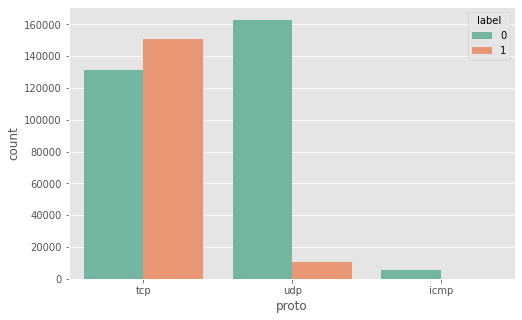

In [ ]:
# let's see protocol type vs. our target(attack) by bar chart

plt.figure(figsize=(8,5))
ax = sns.countplot(x='proto', hue='label', data = df, palette ='Set2')
for container in ax.containers:
    ax.bar_label(container)

## 2.3 Check the distribution for the features

In [ ]:
# Define history plot function for statistic features

def plot_hist(df, cols, title):
    grid = gridspec.GridSpec(10, 2, wspace=0.5, hspace=0.5) 
    fig = plt.figure(figsize=(20,30)) 
    
    for n, col in enumerate(df[cols]):         
        ax = plt.subplot(grid[n]) 

        ax.hist(df[col], bins=20) 
        #ax.set_ylabel('Count', fontsize=12)
        ax.set_title(f'{col} distribution', fontsize=15) 
    fig.suptitle(title, fontsize=20)
    grid.tight_layout(fig, rect=[0, 0, 1, 0.97])
    plt.show()

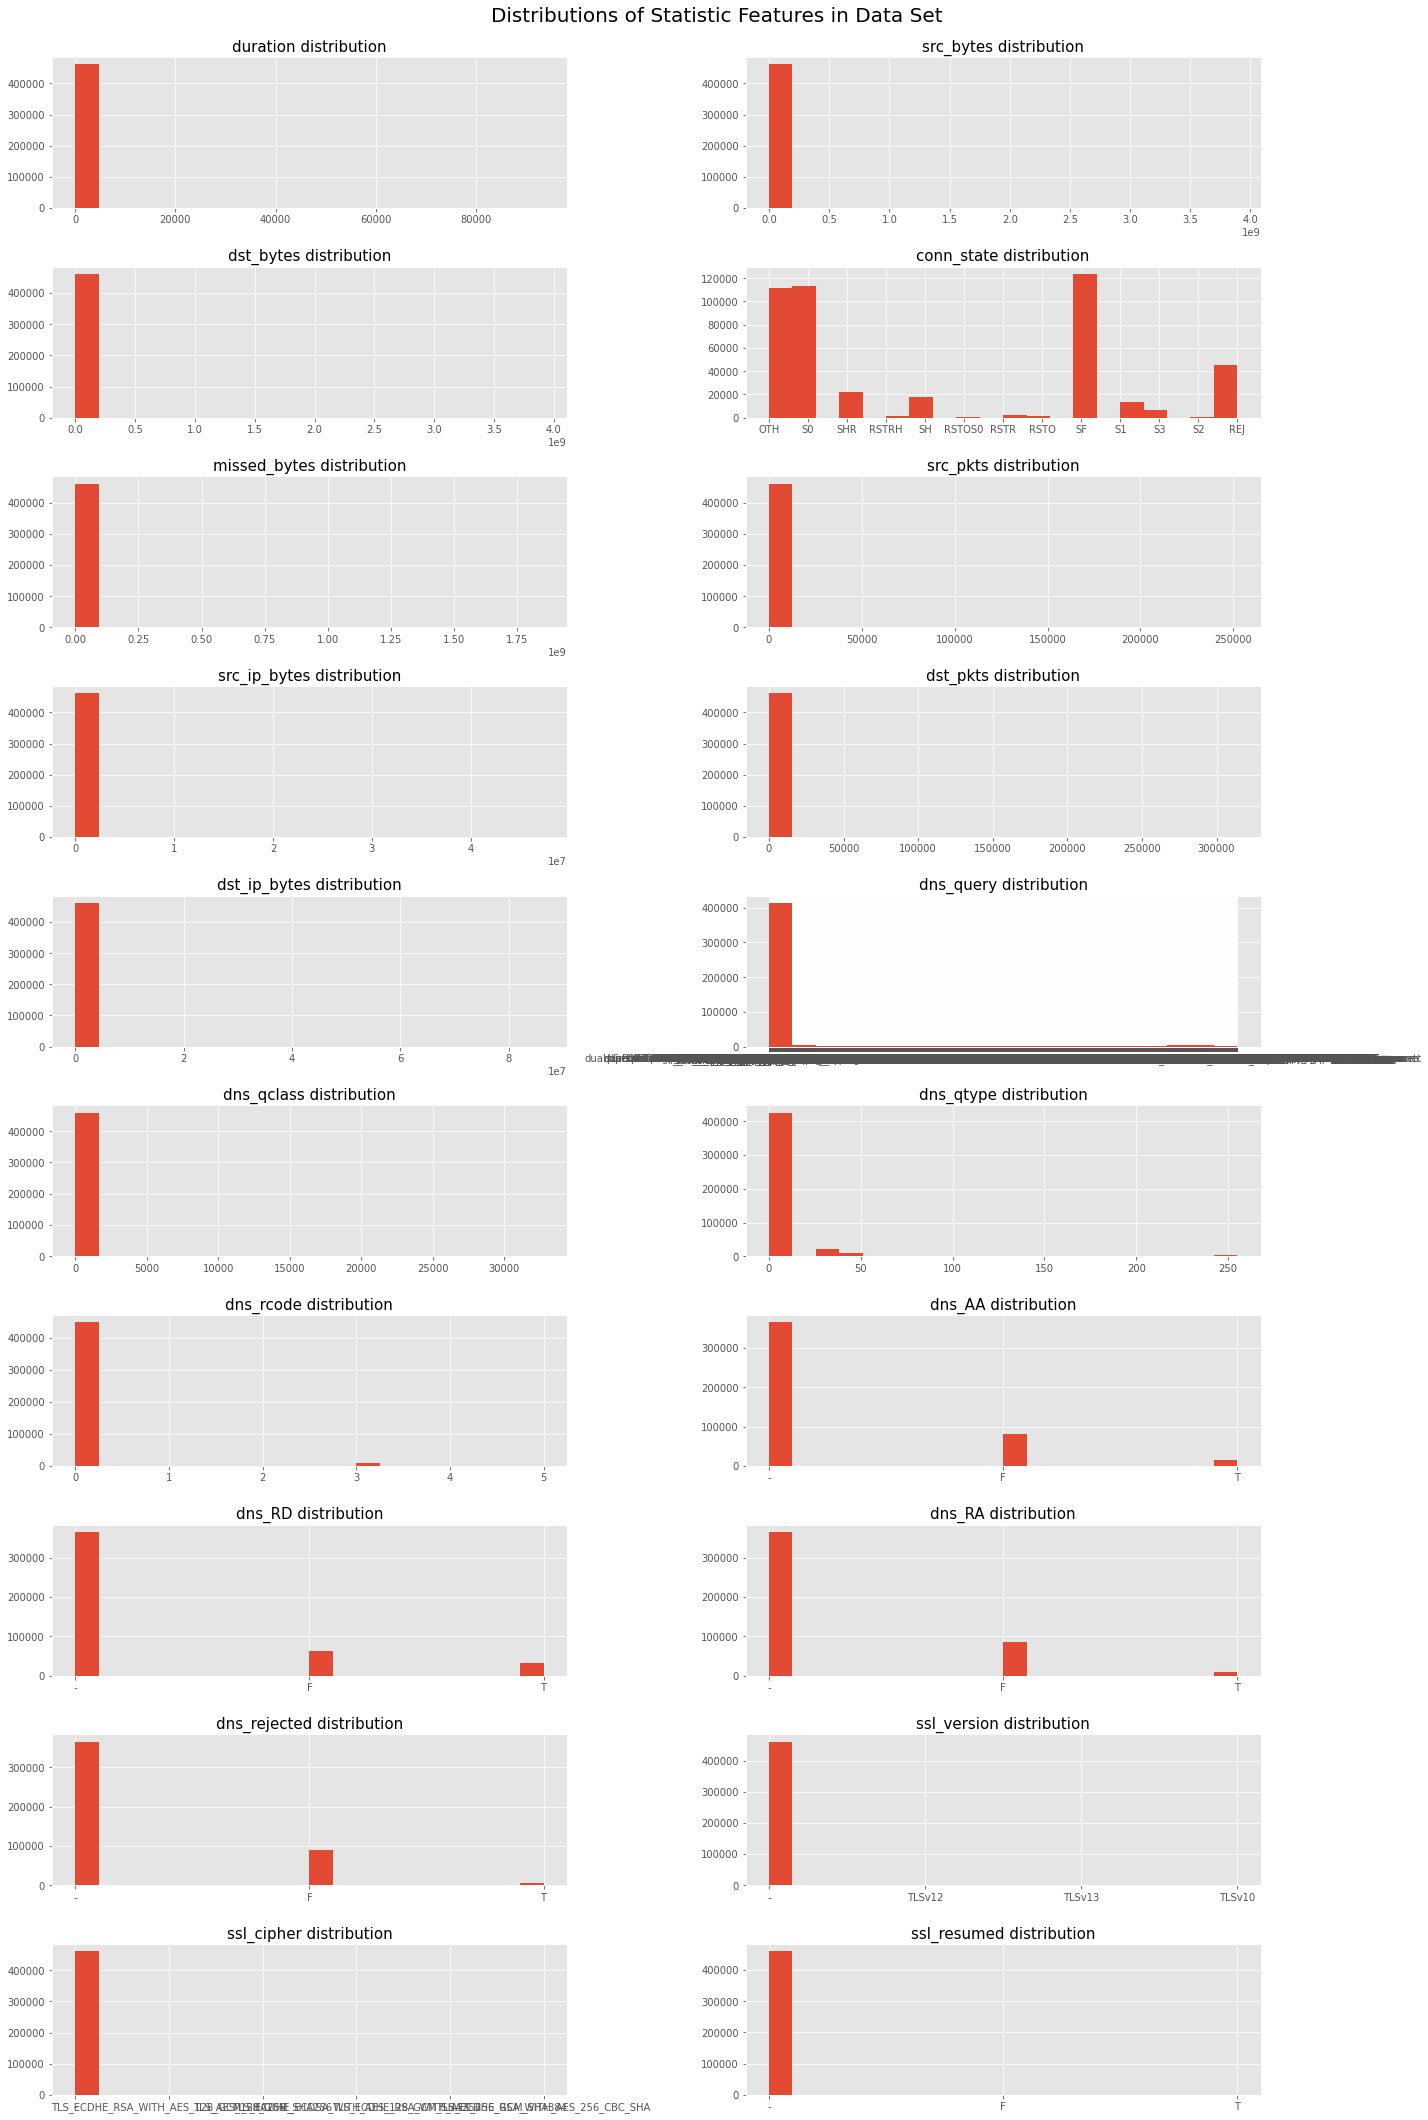

In [ ]:
# using plot_hist function to present plot history of selected statistic features

hist_cols = [ 'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes', \
              'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_query', \
              'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA', 'dns_RD', 'dns_RA', \
              'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed', \
#              'ssl_established', 'ssl_subject', 'ssl_issuer', 'http_trans_depth', \
#              'http_method', 'http_uri', 'http_version', 'http_request_body_len', \
#              'http_response_body_len', 'http_status_code', 'http_user_agent', \
#              'http_orig_mime_types', 'http_resp_mime_types', 'weird_name', \
#              'weird_addl', 'weird_notice'
            ]
    
plot_hist(df, hist_cols, 'Distributions of Statistic Features in Data Set')

ValueError: ignored

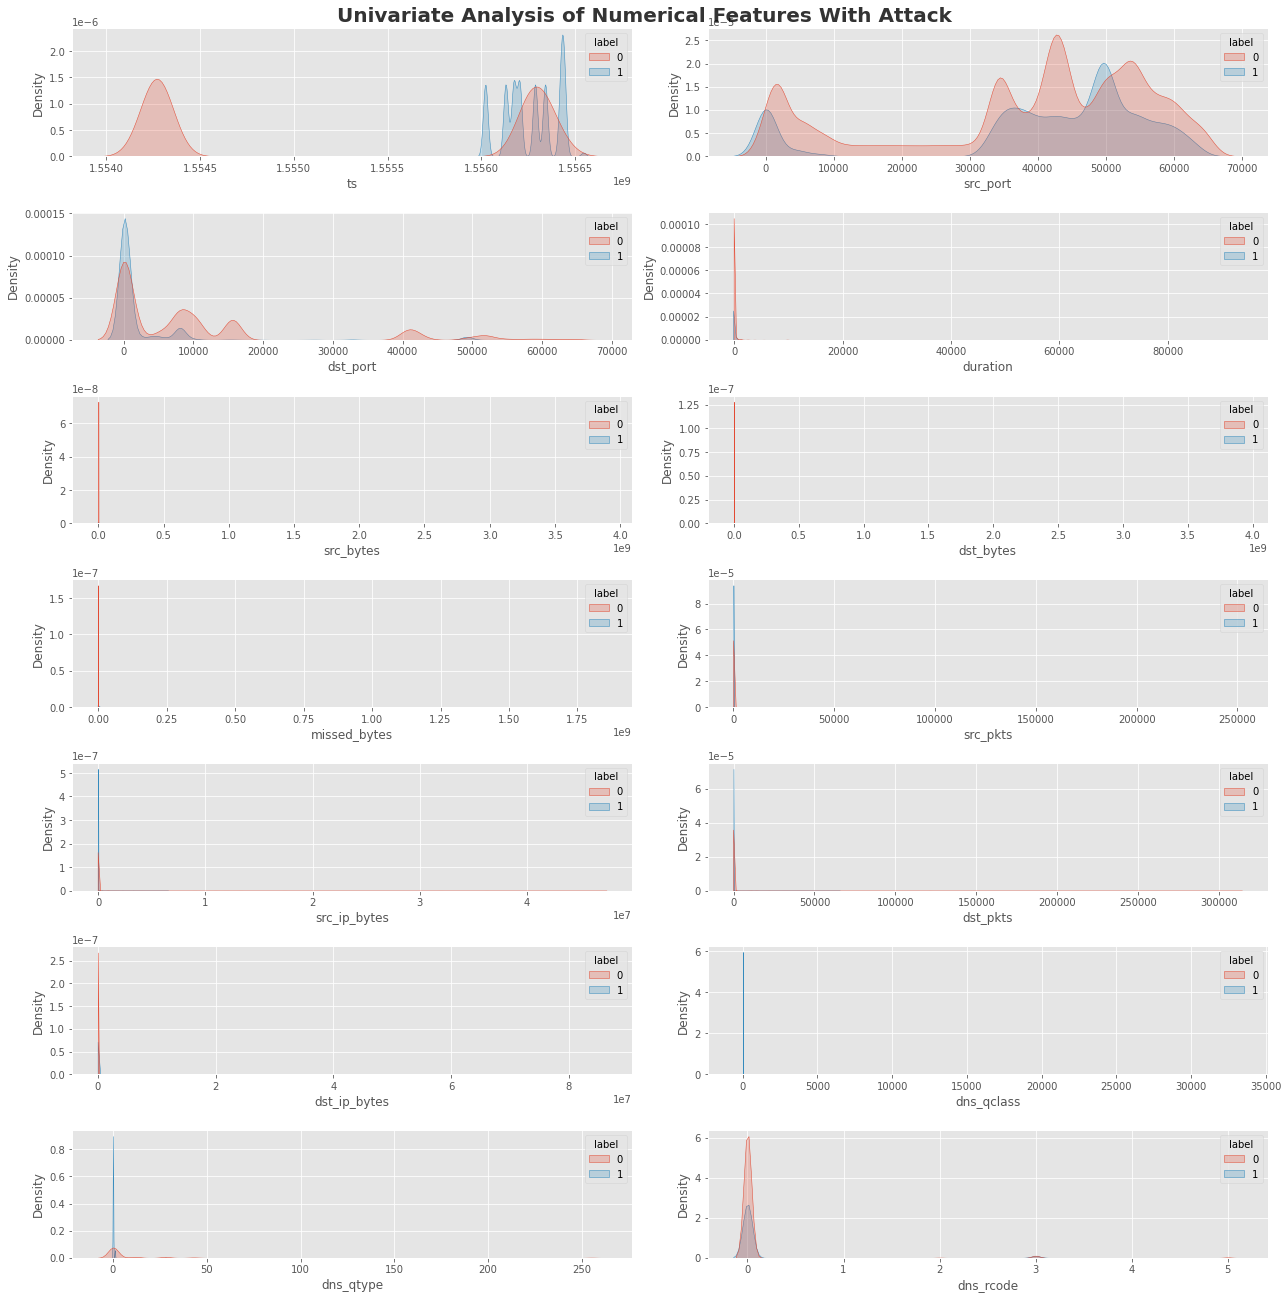

In [ ]:
# Check distribution of each feature towards attack

numeric_features = [i for i in df.columns if df[i].dtype!='O']
categorical_features = [i for i in df.columns if df[i].dtype =='O']

plt.figure(figsize=(18,18))
plt.suptitle('Univariate Analysis of Numerical Features With Attack', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(0, len(numeric_features)):
    plt.subplot(7, 2, i+1)
    sns.kdeplot(x= df[numeric_features[i]], shade=True, hue='label' ,data=df)
    plt.xlabel(numeric_features[i])
    plt.tight_layout()

In [ ]:
for i in df.columns:
    plt.figure(figsize=(18,18))
    sns.displot(data= df,x=i,hue='label',kind='hist')

## 2.4 Check the outlier of each feature

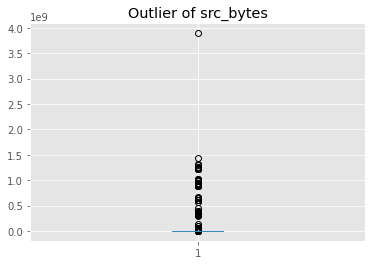

In [ ]:
#plot the outlier of the feature

plt.boxplot(df['src_bytes'])
plt.title('Outlier of src_bytes')
plt.show()

# 3. Data Pre-processing

## 3.1 Handle missing value#

In [ ]:
# check the count of missing value

df.isnull().sum()

ts                        0
src_ip                    0
src_port                  0
dst_ip                    0
dst_port                  0
proto                     0
service                   0
duration                  0
src_bytes                 0
dst_bytes                 0
conn_state                0
missed_bytes              0
src_pkts                  0
src_ip_bytes              0
dst_pkts                  0
dst_ip_bytes              0
dns_query                 0
dns_qclass                0
dns_qtype                 0
dns_rcode                 0
dns_AA                    0
dns_RD                    0
dns_RA                    0
dns_rejected              0
ssl_version               0
ssl_cipher                0
ssl_resumed               0
ssl_established           0
ssl_subject               0
ssl_issuer                0
http_trans_depth          0
http_method               0
http_uri                  0
http_version              0
http_request_body_len     0
http_response_body_l

In [ ]:
# check the count of missing value

df.isna().sum()

ts                        0
src_ip                    0
src_port                  0
dst_ip                    0
dst_port                  0
proto                     0
service                   0
duration                  0
src_bytes                 0
dst_bytes                 0
conn_state                0
missed_bytes              0
src_pkts                  0
src_ip_bytes              0
dst_pkts                  0
dst_ip_bytes              0
dns_query                 0
dns_qclass                0
dns_qtype                 0
dns_rcode                 0
dns_AA                    0
dns_RD                    0
dns_RA                    0
dns_rejected              0
ssl_version               0
ssl_cipher                0
ssl_resumed               0
ssl_established           0
ssl_subject               0
ssl_issuer                0
http_trans_depth          0
http_method               0
http_uri                  0
http_version              0
http_request_body_len     0
http_response_body_l

In [ ]:
# show the features that contain '-' value, which can be regarded as missing value

features_with_missing_value = df.columns[df.isin(['-']).any()]
features_with_missing_value

Index(['service', 'dns_query', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected',
       'ssl_version', 'ssl_cipher', 'ssl_resumed', 'ssl_established',
       'ssl_subject', 'ssl_issuer', 'http_trans_depth', 'http_method',
       'http_uri', 'http_version', 'http_user_agent', 'http_orig_mime_types',
       'http_resp_mime_types', 'weird_name', 'weird_addl', 'weird_notice'],
      dtype='object')

**=> 'service', "dns_xxx", "ssl_xxx", "http_xxx" and 
"weird_xxx" features have "-" value, so the next step is to figure out the meaning of the features and why "-" exists in the data.**



In [18]:
# show the instances that contain '-' value, which can be regarded as missing value
mask = (df == '-').any(axis=1)
indices = df.loc[mask].index
indices

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            461033, 461034, 461035, 461036, 461037, 461038, 461039, 461040,
            461041, 461042],
           dtype='int64', length=461043)

=> The output shows that each instance has at least one "-" value in any feature

In [ ]:
# Check the value counts for the features

df["service"].value_counts()

-             280216
dns           116480
http           60720
ssl             2070
ftp             1065
gssapi           184
dce_rpc          136
smb              108
dhcp              46
smb;gssapi        18
Name: service, dtype: int64

In [ ]:
# Check the value counts for the features

df["dns_query"].value_counts()

-                                                  366019
a2z3kk2ebqzso7.iot.ap-southeast-2.amazonaws.com     13700
arpa.whois-servers.net                               2198
_sleep-proxy._udp.local                              2187
testphp.vulnweb.com                                  1848
                                                    ...  
94.157.81.140.in-addr.arpa                              1
125.48.34.73.in-addr.arpa                               1
101.192.178.247.in-addr.arpa                            1
254.68.212.in-addr.arpa                                 1
loadm.exelator.com                                      1
Name: dns_query, Length: 14149, dtype: int64

In [ ]:
# Check the value counts for the features

df["dns_AA"].value_counts()

-    365158
F     81279
T     14606
Name: dns_AA, dtype: int64

In [ ]:
# Check the value counts for the features

df["dns_RD"].value_counts()

-    365158
F     63106
T     32779
Name: dns_RD, dtype: int64

In [ ]:
# Check the value counts for the features

df["dns_rejected"].value_counts()

-    365158
F     89392
T      6493
Name: dns_rejected, dtype: int64

In [ ]:
# Check the value counts for the features

df["ssl_version"].value_counts()

-         460737
TLSv12       188
TLSv13       116
TLSv10         2
Name: ssl_version, dtype: int64

In [ ]:
# Check the value counts for the features

df["ssl_cipher"].value_counts()

-                                          460737
TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256         176
TLS_AES_128_GCM_SHA256                        116
TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384          11
TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA              2
TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256         1
Name: ssl_cipher, dtype: int64

In [ ]:
# Check the value counts for the features

df["ssl_resumed"].value_counts()

-    460352
F       605
T        86
Name: ssl_resumed, dtype: int64

In [ ]:
# Check the value counts for the features

df["ssl_established"].value_counts()

-    460352
F       596
T        95
Name: ssl_established, dtype: int64

In [ ]:
# Check the value counts for the features

df["ssl_subject"].value_counts()


-                                                                                           461034
CN=*.wns.windows.com                                                                             4
CN=Mr Shepherd;OU=Security Shepherd Project;O=OWASP;L=Dublin;ST=Ireland;C=IE                     2
CN=settings-win.data.microsoft.com;OU=WSE;O=Microsoft;L=Redmond;ST=WA;C=US                       1
CN=sls.update.microsoft.com;OU=DSP;O=Microsoft;L=Redmond;ST=WA;C=US                              1
CN=*.events.data.microsoft.com;OU=Microsoft;O=Microsoft Corporation;L=Redmond;ST=WA;C=US         1
Name: ssl_subject, dtype: int64

In [ ]:
# Check the value counts for the features

df["ssl_issuer"].value_counts()


-                                                                                                461034
CN=Microsoft IT TLS CA 5;OU=Microsoft IT;O=Microsoft Corporation;L=Redmond;ST=Washington;C=US         4
CN=Microsoft Secure Server CA 2011;O=Microsoft Corporation;L=Redmond;ST=Washington;C=US               2
CN=Mr Shepherd;OU=Security Shepherd Project;O=OWASP;L=Dublin;ST=Ireland;C=IE                          2
CN=Microsoft Update Secure Server CA 2.1;O=Microsoft Corporation;L=Redmond;ST=Washington;C=US         1
Name: ssl_issuer, dtype: int64

In [ ]:
# Check the value counts for the features

df["http_trans_depth"].value_counts()

-     460796
1        214
2         25
10         1
3          1
4          1
5          1
6          1
7          1
8          1
9          1
Name: http_trans_depth, dtype: int64

In [ ]:
# Check the value counts for the features

df["http_method"].value_counts()

-       460809
GET        215
POST        15
HEAD         4
Name: http_method, dtype: int64

In [ ]:
# Check the value counts for the features

df["http_uri"].value_counts()


-                                                                                                                                                                                         460809
/no_nonce_string/                                                                                                                                                                             15
/dvwa/login.php-r                                                                                                                                                                             13
/no_nonce_string/ContentDirectory/scpd.xml                                                                                                                                                    12
/filestreamingservice/files/1f41d40e-6e49-42f0-a4dc-3d35029e2a5d?P1=1554315773&P2=402&P3=2&P4=D2MtshBIyXICLz+f8ls5Sa4mWcxA1B670oj1WRainhnd91v77n9XO6/xoc4QeEYZdwdKSG+6cFNvkBVYbJdXpw==         9
                                   

In [ ]:
# Check the value counts for the features

df["http_version"].value_counts()


-      460801
1.1       242
Name: http_version, dtype: int64

In [ ]:
# Check the value counts for the features

df["http_user_agent"].value_counts()

-                                                                                                                                    460809
Microsoft-Delivery-Optimization/10.0                                                                                                     57
Microsoft-Windows/10.0 UPnP/1.0                                                                                                          32
Ruby                                                                                                                                     31
DAFUPnP                                                                                                                                  19
User-Agent: Microsoft-DLNA DLNADOC/1.50                                                                                                  19
Windows-Update-Agent/10.0.10011.16384 Client-Protocol/1.91                                                                               11
MICROSOFT_DEVICE_MET

In [ ]:
# Check the value counts for the features

df["http_orig_mime_types"].value_counts()

-                       461029
application/xml              8
application/soap+xml         6
Name: http_orig_mime_types, dtype: int64

In [ ]:
# Check the value counts for the features

df["http_resp_mime_types"].value_counts()

-                                    460883
application/xml                          63
text/html                                41
image/png                                15
application/vnd.ms-cab-compressed        13
text/plain                               11
application/ocsp-response                 8
text/json                                 4
image/jpeg                                4
application/x-debian-package              1
Name: http_resp_mime_types, dtype: int64

In [ ]:
# Check the value counts for the features

df["weird_name"].value_counts()

-                                   459749
DNS_RR_unknown_type                    753
active_connection_reuse                275
data_before_established                109
bad_UDP_checksum                        68
bad_TCP_checksum                        52
connection_originator_SYN_ack           20
above_hole_data_without_any_acks         6
inappropriate_FIN                        3
dnp3_corrupt_header_checksum             3
possible_split_routing                   3
TCP_ack_underflow_or_misorder            2
Name: weird_name, dtype: int64

In [ ]:
# Check the value counts for the features

df["weird_addl"].value_counts()


-     460290
46       707
48        38
43         8
Name: weird_addl, dtype: int64

In [ ]:
# Check the value counts for the features

df["weird_notice"].value_counts()


-    459749
F      1294
Name: weird_notice, dtype: int64

After checking for the features that contain "-" value (missing value), nearly all the instance have missing value for these features, so we need do imputation for the missing values.
Then what's the imputation mechanism to be used for that? Need to understand the features and why the value is missing? (type of missing value)

## 3.2 Handle duplicate instance

In [ ]:
# Check the duplicated instance

df.duplicated().sum()

#Reference
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html

11071

In [ ]:
# List instances duplicated

duplicates = df[df.duplicated()]
duplicates

#duplicates = df[df.duplicated(keep = False)]
#keep : {‘first’, ‘last’, False}, default ‘first’

#'first' : Mark duplicates as True except for the first occurrence.
#'last' : Mark duplicates as True except for the last occurrence.
#False : Mark all duplicates as True.

,ts,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
12679,1554220499,192.168.1.250,5353,224.0.0.251,5353,udp,dns,0.0,0,0,...,0,0,-,-,-,-,-,-,0,normal
12699,1554220514,192.168.1.133,5353,224.0.0.251,5353,udp,dns,0.0,0,0,...,0,0,-,-,-,-,-,-,0,normal
12813,1554220595,192.168.1.133,5353,224.0.0.251,5353,udp,dns,0.0,0,0,...,0,0,-,-,-,-,-,-,0,normal
12996,1554220744,192.168.1.79,43029,192.168.1.255,15600,udp,-,0.0,0,0,...,0,0,-,-,-,-,-,-,0,normal
13124,1554220864,192.168.1.195,138,192.168.1.255,138,udp,-,0.0,0,0,...,0,0,-,-,-,-,-,-,0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420021,1556423639,192.168.1.195,49884,13.107.4.50,80,tcp,-,0.0,0,0,...,0,0,-,-,-,-,-,-,0,normal
420022,1556423639,192.168.1.195,49885,13.107.4.50,80,tcp,-,0.0,0,0,...,0,0,-,-,-,-,-,-,0,normal
420023,1556423639,192.168.1.195,49884,13.107.4.50,80,tcp,-,0.0,0,0,...,0,0,-,-,-,-,-,-,0,normal
420024,1556423639,192.168.1.195,49885,13.107.4.50,80,tcp,-,0.0,0,0,...,0,0,-,-,-,-,-,-,0,normal


As we can see, there are 11071 rows are duplicated in the data set. we need consider the mechanism to handle. If there is no any important information, we may directly drop the duplicate instances.

## 3.3 Check non-numerical value

In [ ]:
# Check the type of each feature

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461043 entries, 0 to 461042
Data columns (total 45 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ts                      461043 non-null  int64  
 1   src_ip                  461043 non-null  object 
 2   src_port                461043 non-null  int64  
 3   dst_ip                  461043 non-null  object 
 4   dst_port                461043 non-null  int64  
 5   proto                   461043 non-null  object 
 6   service                 461043 non-null  object 
 7   duration                461043 non-null  float64
 8   src_bytes               461043 non-null  int64  
 9   dst_bytes               461043 non-null  int64  
 10  conn_state              461043 non-null  object 
 11  missed_bytes            461043 non-null  int64  
 12  src_pkts                461043 non-null  int64  
 13  src_ip_bytes            461043 non-null  int64  
 14  dst_pkts            

From the output, there are many non-numerical features, or object type for the features.

In [ ]:
df.head().T

,0,1,2,3,4
ts,1554198358,1554198358,1554198359,1554198359,1554198362
src_ip,3.122.49.24,192.168.1.79,192.168.1.152,192.168.1.152,192.168.1.152
src_port,1883,47260,1880,34296,46608
dst_ip,192.168.1.152,192.168.1.255,192.168.1.152,192.168.1.152,192.168.1.190
dst_port,52976,15600,51782,10502,53
proto,tcp,udp,tcp,tcp,udp
service,-,-,-,-,dns
duration,80549.53026,0.0,0.0,0.0,0.000549
src_bytes,1762852,0,0,0,0
dst_bytes,41933215,0,0,0,298


## 3.4 Feature Elimination by understanding the dataset

After understanding each feature in the dataset, we decide to drop following features:

In [ ]:
# Drop the columns (features) that has no relationship with the pattern we try to find
# 'pkSeqID', 'stime', 'saddr', 'sport', 'daddr', 'dport', 'ltime', 'seq'

df_fe1 = df.drop(['pkSeqID', 'stime', 'saddr', 'sport', 'daddr', 'dport', 'ltime', 'seq'], axis=1)

In [ ]:
df_fe1.head()

,flgs,flgs_number,proto,proto_number,pkts,bytes,state,state_number,dur,mean,...,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,AR_P_Proto_P_Dport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
0,e,1,tcp,1,8,1980,RST,1,7.056393,0.068909,...,1.12704,96.0,75.0,1.133720,1.129970,770.0,602.0,1.0,DoS,HTTP
1,e,1,arp,2,2,120,CON,2,0.000131,0.000131,...,15267.20000,1.0,2.0,0.005142,0.005142,2.0,6.0,1.0,DoS,HTTP
2,e,1,tcp,1,8,2126,RST,1,7.047852,0.064494,...,1.12704,96.0,75.0,1.135100,1.129970,770.0,602.0,1.0,DoS,HTTP
3,e,1,tcp,1,8,2024,RST,1,7.047592,0.064189,...,1.12704,96.0,75.0,1.135140,1.129970,770.0,602.0,1.0,DoS,HTTP
4,e,1,tcp,1,8,2319,RST,1,7.046841,0.063887,...,1.12704,96.0,75.0,1.135260,1.129970,770.0,602.0,1.0,DoS,HTTP


In [ ]:
df_fe1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249056 entries, 0 to 249058
Data columns (total 38 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   flgs                              249056 non-null  object 
 1   flgs_number                       249056 non-null  int64  
 2   proto                             249056 non-null  object 
 3   proto_number                      249056 non-null  int64  
 4   pkts                              249056 non-null  int64  
 5   bytes                             249056 non-null  int64  
 6   state                             249056 non-null  object 
 7   state_number                      249056 non-null  int64  
 8   dur                               249056 non-null  float64
 9   mean                              249056 non-null  float64
 10  stddev                            249056 non-null  float64
 11  sum                               249056 non-null  f

In [ ]:
# Since the attributes are the same for 'flgs' and 'flgs_number', 'proto' and 'proto_number', 'state' and 'state_number'
# So we just need one of each pair.
# Drop the columns (features) 'flgs_number', 'proto_number', 'state_number'.

df_fe2 = df_fe1.drop(['flgs_number', 'proto_number', 'state_number'], axis=1)


In [ ]:
df_fe2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249056 entries, 0 to 249058
Data columns (total 35 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   flgs                              249056 non-null  object 
 1   proto                             249056 non-null  object 
 2   pkts                              249056 non-null  int64  
 3   bytes                             249056 non-null  int64  
 4   state                             249056 non-null  object 
 5   dur                               249056 non-null  float64
 6   mean                              249056 non-null  float64
 7   stddev                            249056 non-null  float64
 8   sum                               249056 non-null  float64
 9   min                               249056 non-null  float64
 10  max                               249056 non-null  float64
 11  spkts                             249056 non-null  f

## 3.5 Handling Non-numerical Values

In [ ]:
# let's encoding our categorical features using one-hot encoding

df_fe2_he = pd.get_dummies(df_fe2, columns = ['flgs', 'proto', 'state'])

In [ ]:
df_fe2_he.head().T

,0,1,2,3,4
pkts,8,2,8,8,8
bytes,1980,120,2126,2024,2319
dur,7.056393,0.000131,7.047852,7.047592,7.046841
mean,0.068909,0.000131,0.064494,0.064189,0.063887
stddev,0.068909,0.0,0.064494,0.064189,0.063887
sum,0.137818,0.000131,0.128988,0.128378,0.127774
min,0.0,0.000131,0.0,0.0,0.0
max,0.137818,0.000131,0.128988,0.128378,0.127774
spkts,5.0,1.0,5.0,5.0,5.0
dpkts,3.0,1.0,3.0,3.0,3.0


In [ ]:
df_fe2_he.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249056 entries, 0 to 249058
Data columns (total 46 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   pkts                              249056 non-null  int64  
 1   bytes                             249056 non-null  int64  
 2   dur                               249056 non-null  float64
 3   mean                              249056 non-null  float64
 4   stddev                            249056 non-null  float64
 5   sum                               249056 non-null  float64
 6   min                               249056 non-null  float64
 7   max                               249056 non-null  float64
 8   spkts                             249056 non-null  float64
 9   dpkts                             249056 non-null  float64
 10  sbytes                            249056 non-null  float64
 11  dbytes                            249056 non-null  f

In [ ]:
# change the order of the columns that added by hot encoding

df_fe2_he1 = df_fe2_he[['flgs_e', 'flgs_e *', 'flgs_e d', 'flgs_e g', 'flgs_e s', 'flgs_eU', 'proto_arp', 'proto_tcp', \
           'proto_udp', 'state_ACC', 'state_CON', 'state_INT', 'state_REQ', 'state_RST', \
           'pkts', 'bytes', 'dur', 'mean', 'stddev', 'sum', 'min', \
           'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate', \
           'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', \
           'TnP_Per_Dport', 'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', \
           'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', \
           'AR_P_Proto_P_Dport', 'Pkts_P_State_P_Protocol_P_DestIP', \
           'Pkts_P_State_P_Protocol_P_SrcIP', 'attack', 'category', 'subcategory' ]]


In [ ]:
df_fe2_he1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249056 entries, 0 to 249058
Data columns (total 46 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   flgs_e                            249056 non-null  uint8  
 1   flgs_e *                          249056 non-null  uint8  
 2   flgs_e d                          249056 non-null  uint8  
 3   flgs_e g                          249056 non-null  uint8  
 4   flgs_e s                          249056 non-null  uint8  
 5   flgs_eU                           249056 non-null  uint8  
 6   proto_arp                         249056 non-null  uint8  
 7   proto_tcp                         249056 non-null  uint8  
 8   proto_udp                         249056 non-null  uint8  
 9   state_ACC                         249056 non-null  uint8  
 10  state_CON                         249056 non-null  uint8  
 11  state_INT                         249056 non-null  u

## 3.6 Data normalization (feature scaling)

In [ ]:
# Feature Scaling using Min-Max Scaling
from sklearn.preprocessing import MinMaxScaler

# instantiate the MinMaxScaler
scaler = MinMaxScaler()

# Set predictor and target variables
X = df_fe2_he1.drop(['attack', 'category', 'subcategory'], axis =1)
y1 = df_fe2_he1['attack']
y2 = df_fe2_he1['category']
y3 = df_fe2_he1['subcategory']

# fit the scaler to the data
scaler.fit(X)

# transform the data using the fitted scaler
X_fsmm = scaler.transform(X)

# Put the tranformed X into dataframe
df_fe2_he1_fsmm = pd.DataFrame(X_fsmm, index = X.index, columns = X.columns)

In [ ]:
df_fe2_he1_fsmm.head()

,flgs_e,flgs_e *,flgs_e d,flgs_e g,flgs_e s,flgs_eU,proto_arp,proto_tcp,proto_udp,state_ACC,...,TnP_PerProto,TnP_Per_Dport,AR_P_Proto_P_SrcIP,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,AR_P_Proto_P_Dport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.514019,0.514019,0.000072,0.000074,0.959596,0.747475,0.000085,0.000085,0.512684,0.400534
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.004005,0.004005,0.000000,1.000000,0.000000,0.010101,0.000000,0.000000,0.000000,0.002670
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.514019,0.514019,0.000072,0.000074,0.959596,0.747475,0.000085,0.000085,0.512684,0.400534
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.514019,0.514019,0.000072,0.000074,0.959596,0.747475,0.000085,0.000085,0.512684,0.400534
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.514019,0.514019,0.000072,0.000074,0.959596,0.747475,0.000085,0.000085,0.512684,0.400534


In [ ]:
# We need generate the data with normalised X combined with target y.

normalized_data = pd.concat([df_fe2_he1_fsmm, y1, y2, y3], axis=1)

In [ ]:
# check the normalized data

normalized_data.head().T

,0,1,2,3,4
flgs_e,1.0,1.0,1.0,1.0,1.0
flgs_e *,0.0,0.0,0.0,0.0,0.0
flgs_e d,0.0,0.0,0.0,0.0,0.0
flgs_e g,0.0,0.0,0.0,0.0,0.0
flgs_e s,0.0,0.0,0.0,0.0,0.0
flgs_eU,0.0,0.0,0.0,0.0,0.0
proto_arp,0.0,1.0,0.0,0.0,0.0
proto_tcp,1.0,0.0,1.0,1.0,1.0
proto_udp,0.0,0.0,0.0,0.0,0.0
state_ACC,0.0,0.0,0.0,0.0,0.0


In [ ]:
# save the transformed data to csv file

normalized_data.to_csv('BoT-IoT_normalized.csv', index=False)

**Till now, basic data-preprocessing involving, handing missing value, duplicate instance, non-numerical value, invalid feature elimination by understanding the data, and normalization by min-max scaling.**

# 4. Data Processing

## 4.1 Feature ranking

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

data = normalized_data

# Set predictor and target variables
X = data.drop(['attack', 'category', 'subcategory'], axis =1)
y1 = data['attack']
y2 = data['category']
y3 = data['subcategory']

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y2)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

NameError: ignored